In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
path='https://raw.githubusercontent.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/master/perrin-freres-monthly-champagne-.csv'
df=pd.read_csv(path)
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [64]:
df.columns=['Month','Sales']

In [65]:
df.dropna(inplace=True,axis=0)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [67]:
df['Month']=pd.to_datetime(df['Month'])

In [68]:
df.set_index('Month',inplace=True)

In [69]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [70]:
df.tail()

,Sales
Month,
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0
1972-08-01,1413.0
1972-09-01,5877.0


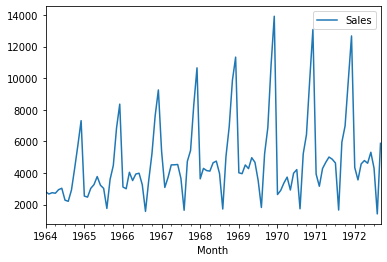

In [9]:
df.plot()

In [10]:
#check stationary
from statsmodels.tsa.stattools import adfuller

In [11]:
#adfuller(df['Sales'])

def check_stationary (sales):
  result=adfuller(sales)
  features=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
  for value,feature in zip(result,features):
    print(feature +':'+str(value))
  if result[1]<=0.05:
    print('stationary')
  else:
    print('Not stationary')

In [12]:
check_stationary(df['Sales'])

ADF Test Statistic:-1.8335930563276226
p-value:0.3639157716602452
#Lags Used:11
Number of Observations Used:93
Not stationary


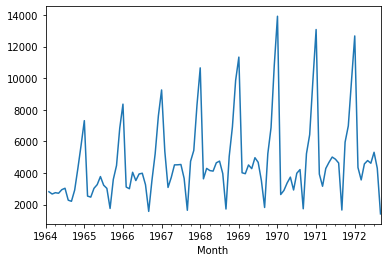

In [13]:
#Differencing
df['Sales'].shift(1).plot()

In [14]:
check_stationary(df['Sales'].shift(1).dropna())

ADF Test Statistic:-1.7636531217185163
p-value:0.3986502906962067
#Lags Used:11
Number of Observations Used:92
Not stationary


In [15]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)
check_stationary(df['Seasonal First Difference'].dropna())

ADF Test Statistic:-7.626619157213164
p-value:2.060579696813685e-11
#Lags Used:0
Number of Observations Used:92
stationary


In [16]:
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
!pip install pmdarima

In [17]:
#Figure Out Order for ARIMA Model
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [18]:
arima_parm=auto_arima(df['Sales'],suppress_warnings=True)

In [19]:
arima_parm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -966.875
Date:                Fri, 02 Apr 2021   AIC                           1935.750
Time:                        20:06:52   BIC                           1938.394
Sample:                             0   HQIC                          1936.821
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.895e+06   5.29e+05     13.025      0.000    5.86e+06    7.93e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):               139.51
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               4.62   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA model

In [20]:
from statsmodels.tsa.arima_model import ARIMA

In [22]:
model=ARIMA(df['Sales'],order=(0, 1, 0))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -966.866
Method:                           css   S.D. of innovations           2638.192
Date:                Fri, 02 Apr 2021   AIC                           1937.732
Time:                        20:09:25   BIC                           1943.021
Sample:                    02-01-1964   HQIC                          1939.874
                         - 09-01-1972                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.4423    258.696      0.114      0.909    -477.593     536.477
==============================================================================
"""

In [25]:
df['Forecast']=model_fit.predict(start=80,end=103,dynamic=True)

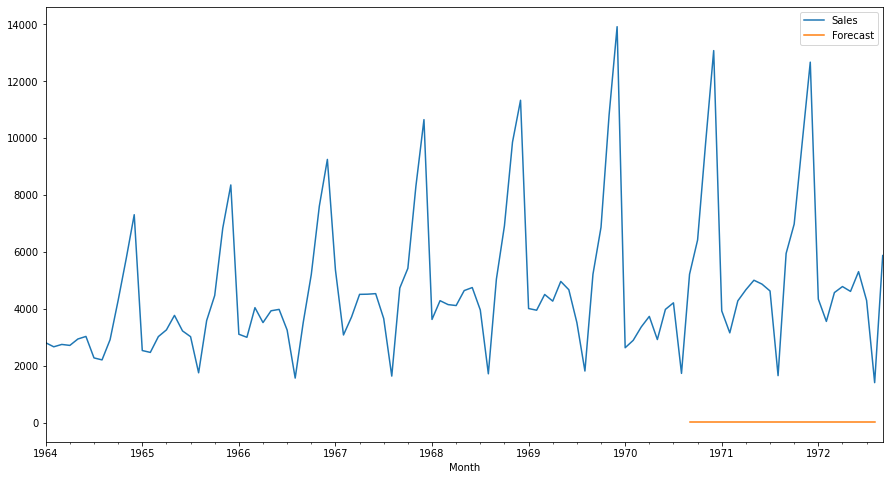

In [26]:
df[['Sales','Forecast']].plot(figsize=(15,8))

Its not warking well because it is seasonal data

**SARIMAX**

In [27]:
#it is seasonal data
import statsmodels.api as sm

In [35]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(0, 1, 0),seasonal_order=(0,1,0,12))
model_fit=model.fit()

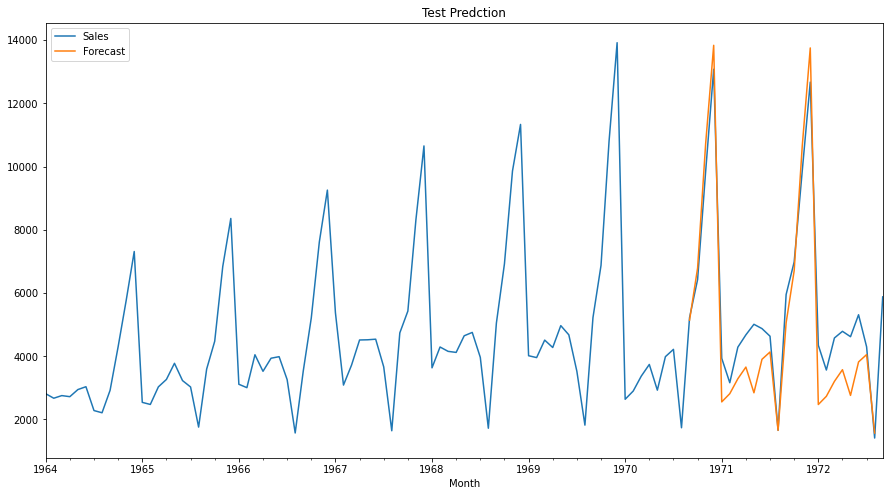

In [85]:
df['Forecast']=model_fit.predict(start=80,end=103,dynamic=True)
df[['Sales','Forecast']].plot(figsize=(15,8),title="Test Predction")

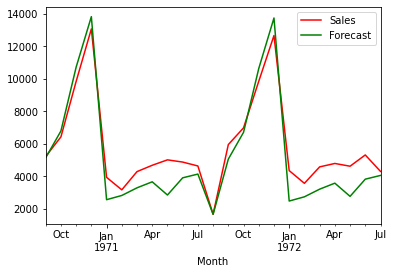

In [43]:
test=df['Sales'].iloc[80:103]
test.plot(color='red',legend=True)
df['Forecast'].iloc[80:103].plot(color='green',legend=True)

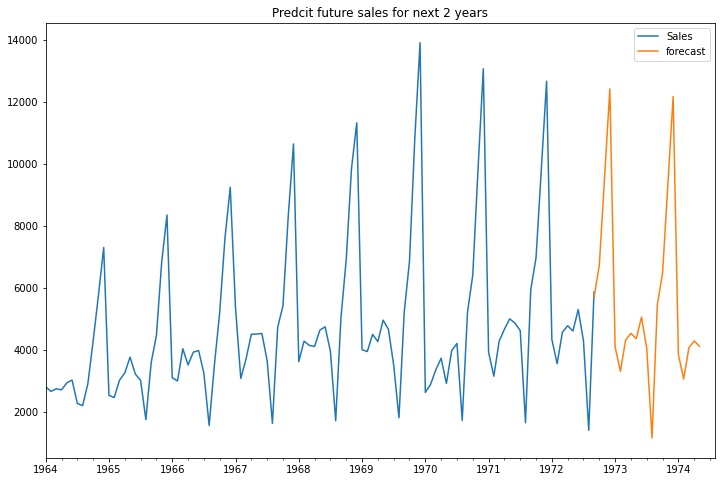

In [84]:
#predcit future sales
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df=pd.concat([df,future_datest_df])

future_df['forecast'] = model_fit.predict(start = 104, end = 124, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8),title='Predcit future sales for next 2 years')